In [1]:
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_data_dir = "/content/drive/My Drive/chest_xray/train"
test_data_dir = "/content/drive/My Drive/chest_xray/test"
val_data_dir = "/content/drive/My Drive/chest_xray/val"

In [4]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,
)

datagen = ImageDataGenerator(rescale= 1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (64,64), 
    color_mode= 'rgb',
    batch_size= 64,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 42
) 

Found 2256 images belonging to 2 classes.


In [6]:
img_width=64
img_height=64

In [7]:
test_generator = datagen.flow_from_directory(
    val_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb', 
    class_mode= 'categorical', 
    batch_size= 64, 
    shuffle= True
)

Found 16 images belonging to 2 classes.


In [8]:
vgg16 = applications.VGG16(include_top= False, input_shape= (img_width, img_height,3), weights= 'imagenet')
vgg16.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [9]:
model = Sequential()

for layer in vgg16.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable= False

model.add(Flatten(input_shape= (2, 2, 512)))

model.add(Dense(512, activation= 'relu', name= 'FC1'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(512, activation= 'relu', name= 'FC2'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(2, activation= 'softmax', name= 'FC3'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)       2

In [10]:
model.compile(optimizer= keras.optimizers.Adam(), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [13]:
history = model.fit(
    train_generator, 
    epochs= 10,
    validation_data = test_generator, 
    verbose = 2, 
    shuffle = True
)

Epoch 1/10
36/36 - 341s - loss: 0.9622 - accuracy: 0.5740 - val_loss: 0.6354 - val_accuracy: 0.6250
Epoch 2/10
36/36 - 118s - loss: 0.8962 - accuracy: 0.6011 - val_loss: 0.6276 - val_accuracy: 0.6250
Epoch 3/10
36/36 - 118s - loss: 0.7884 - accuracy: 0.6272 - val_loss: 0.6068 - val_accuracy: 0.6250
Epoch 4/10
36/36 - 117s - loss: 0.7359 - accuracy: 0.6494 - val_loss: 0.6007 - val_accuracy: 0.5625
Epoch 5/10
36/36 - 115s - loss: 0.6983 - accuracy: 0.6729 - val_loss: 0.5715 - val_accuracy: 0.6875
Epoch 6/10
36/36 - 114s - loss: 0.6282 - accuracy: 0.7119 - val_loss: 0.5772 - val_accuracy: 0.6875
Epoch 7/10
36/36 - 114s - loss: 0.6174 - accuracy: 0.7261 - val_loss: 0.6061 - val_accuracy: 0.5625
Epoch 8/10
36/36 - 116s - loss: 0.5759 - accuracy: 0.7238 - val_loss: 0.5812 - val_accuracy: 0.5625
Epoch 9/10
36/36 - 116s - loss: 0.4975 - accuracy: 0.7748 - val_loss: 0.6423 - val_accuracy: 0.5625
Epoch 10/10
36/36 - 115s - loss: 0.4683 - accuracy: 0.7921 - val_loss: 0.6546 - val_accuracy: 0.6250

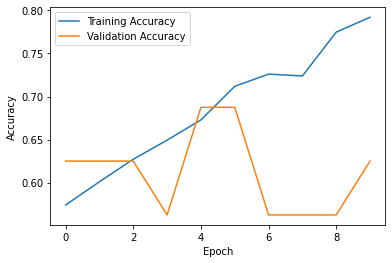

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

In [17]:
!mkdir -p saved_model
model.save('/my_model')

INFO:tensorflow:Assets written to: /my_model/assets
